In [4]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
#Loading training and validation dataset
col=['Id' , 'Entity' , 'Sentiment' , 'Content']
df_train=pd.read_csv(r"C:\Users\ACER\OneDrive\twitter_training.csv" , names=col)
df_test=pd.read_csv(r"C:\Users\ACER\OneDrive\twitter_validation.csv" , names=col)
#Display the data
train_head = df_train.head()
validation_head = df_test.head()

train_head, validation_head

(     Id       Entity Sentiment  \
 0  2401  Borderlands  Positive   
 1  2401  Borderlands  Positive   
 2  2401  Borderlands  Positive   
 3  2401  Borderlands  Positive   
 4  2401  Borderlands  Positive   
 
                                              Content  
 0  im getting on borderlands and i will murder yo...  
 1  I am coming to the borders and I will kill you...  
 2  im getting on borderlands and i will kill you ...  
 3  im coming on borderlands and i will murder you...  
 4  im getting on borderlands 2 and i will murder ...  ,
      Id     Entity   Sentiment  \
 0  3364   Facebook  Irrelevant   
 1   352     Amazon     Neutral   
 2  8312  Microsoft    Negative   
 3  4371      CS-GO    Negative   
 4  4433     Google     Neutral   
 
                                              Content  
 0  I mentioned on Facebook that I was struggling ...  
 1  BBC News - Amazon boss Jeff Bezos rejects clai...  
 2  @Microsoft Why do I pay for WORD when it funct...  
 3  CSGO matchm

In [ ]:
Data Cleaning

In [5]:
df_train.columns=['TweetID','entity','sentiment','Tweet content']
df_train.head()

,TweetID,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
df_test.columns=['TweetID','entity','sentiment','Tweet content']
df_test.head()

,TweetID,entity,sentiment,Tweet content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [7]:
#Checking for missing values
missing_train = df_train.isnull().sum()
missing_validation = df_test.isnull().sum()
#Checking for duplicate rows
duplicates_train = df_train.duplicated().sum()
duplicates_validation = df_test.duplicated().sum()

missing_train, missing_validation, duplicates_train, duplicates_validation

(TweetID            0
 entity             0
 sentiment          0
 Tweet content    686
 dtype: int64,
 TweetID          0
 entity           0
 sentiment        0
 Tweet content    0
 dtype: int64,
 2701,
 0)

In [8]:
#Checking the distribution of sentiment labels
train_sentiment_distribution = df_train.iloc[:, 2].value_counts()
validation_sentiment_distribution = df_test.iloc[:, 2].value_counts()
#Checking the number of unique entities in the training set
unique_entities_train = df_train.iloc[:, 1].nunique()

train_sentiment_distribution, validation_sentiment_distribution, unique_entities_train

(sentiment
 Negative      22542
 Positive      20832
 Neutral       18318
 Irrelevant    12990
 Name: count, dtype: int64,
 sentiment
 Neutral       285
 Positive      277
 Negative      266
 Irrelevant    172
 Name: count, dtype: int64,
 32)

In [9]:
#Removing duplicate rows from the training set
train_data_cleaned = df_train.drop_duplicates()
#Dropping rows with missing tweet/message values
train_data_cleaned = train_data_cleaned.dropna(subset=[df_train.columns[3]])
#Verifying the cleaning
remaining_duplicates_train = train_data_cleaned.duplicated().sum()
remaining_missing_train = train_data_cleaned.isnull().sum()
remaining_duplicates_train, remaining_missing_train

(0,
 TweetID          0
 entity           0
 sentiment        0
 Tweet content    0
 dtype: int64)

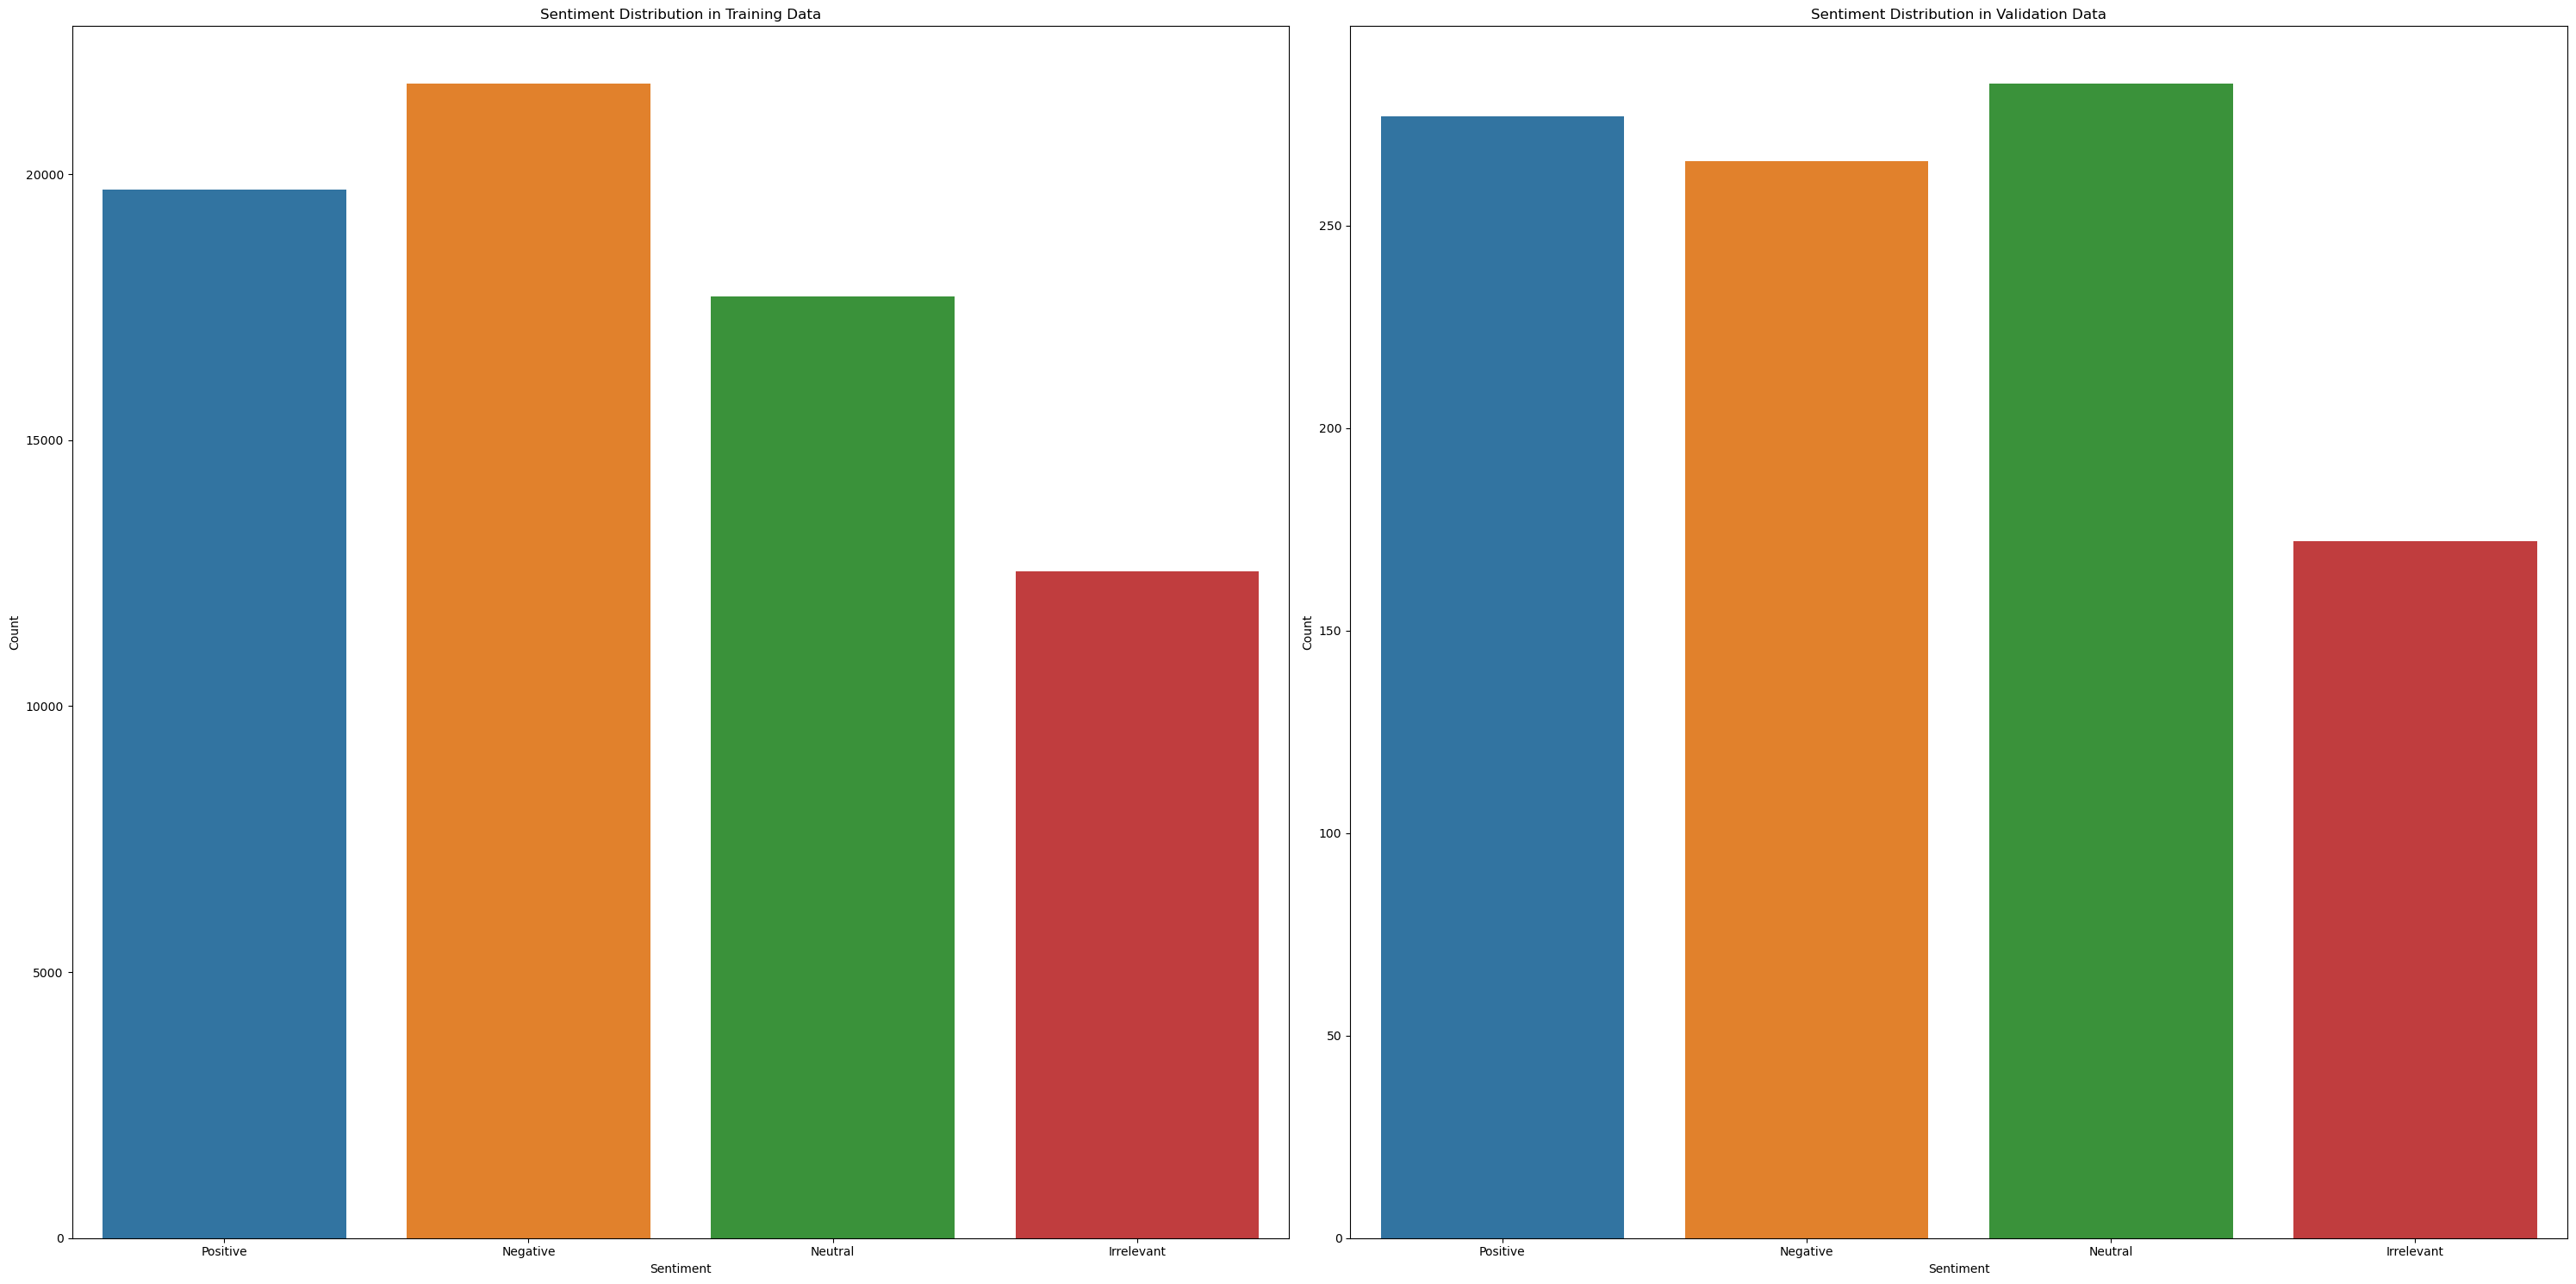

In [10]:
#Setting up the plots
fig, ax = plt.subplots(1, 2, figsize=(30, 15))

#Plotting sentiment distribution for training data
sns.countplot(data=train_data_cleaned, x=train_data_cleaned.columns[2], order=['Positive', 'Negative', 'Neutral', 'Irrelevant'], ax=ax[0])
ax[0].set_title('Sentiment Distribution in Training Data')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Sentiment')

#Plotting sentiment distribution for validation data
sns.countplot(data=df_test, x=df_test.columns[2], order=['Positive', 'Negative', 'Neutral', 'Irrelevant'], ax=ax[1])
ax[1].set_title('Sentiment Distribution in Validation Data')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Sentiment')

plt.tight_layout()
plt.show()

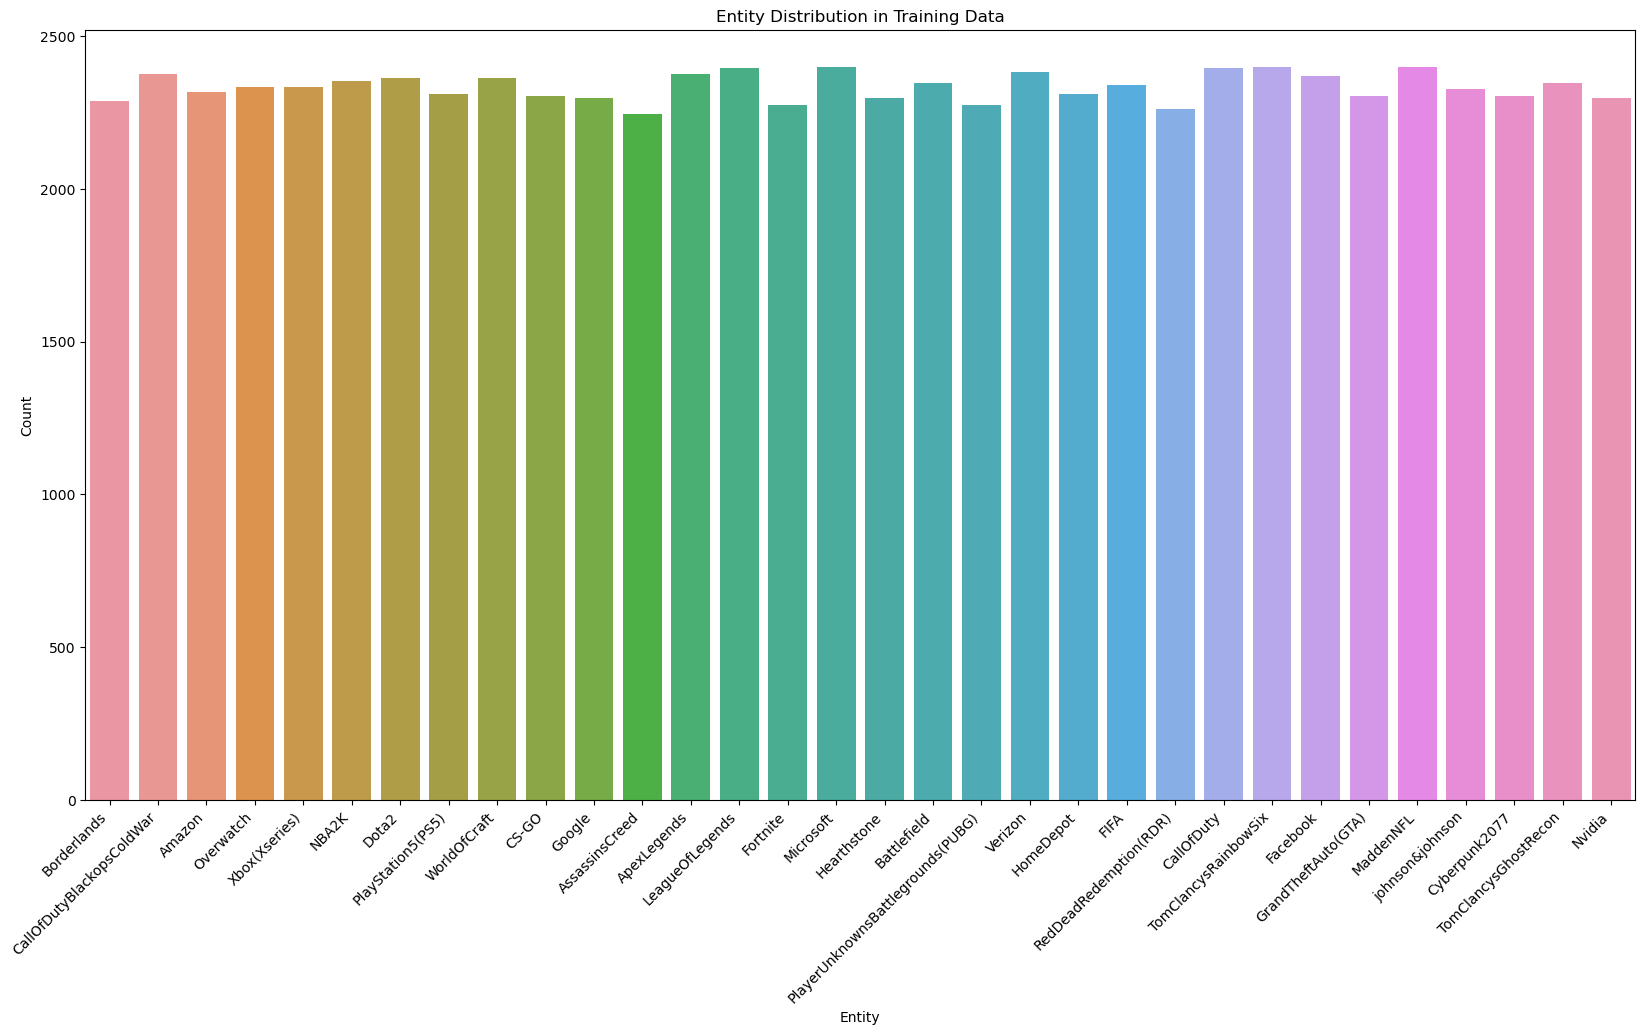

In [12]:
# Plot entity distribution in training data
plt.figure(figsize=(20, 10))
sns.countplot(x='entity', data=df_train)
plt.title('Entity Distribution in Training Data')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


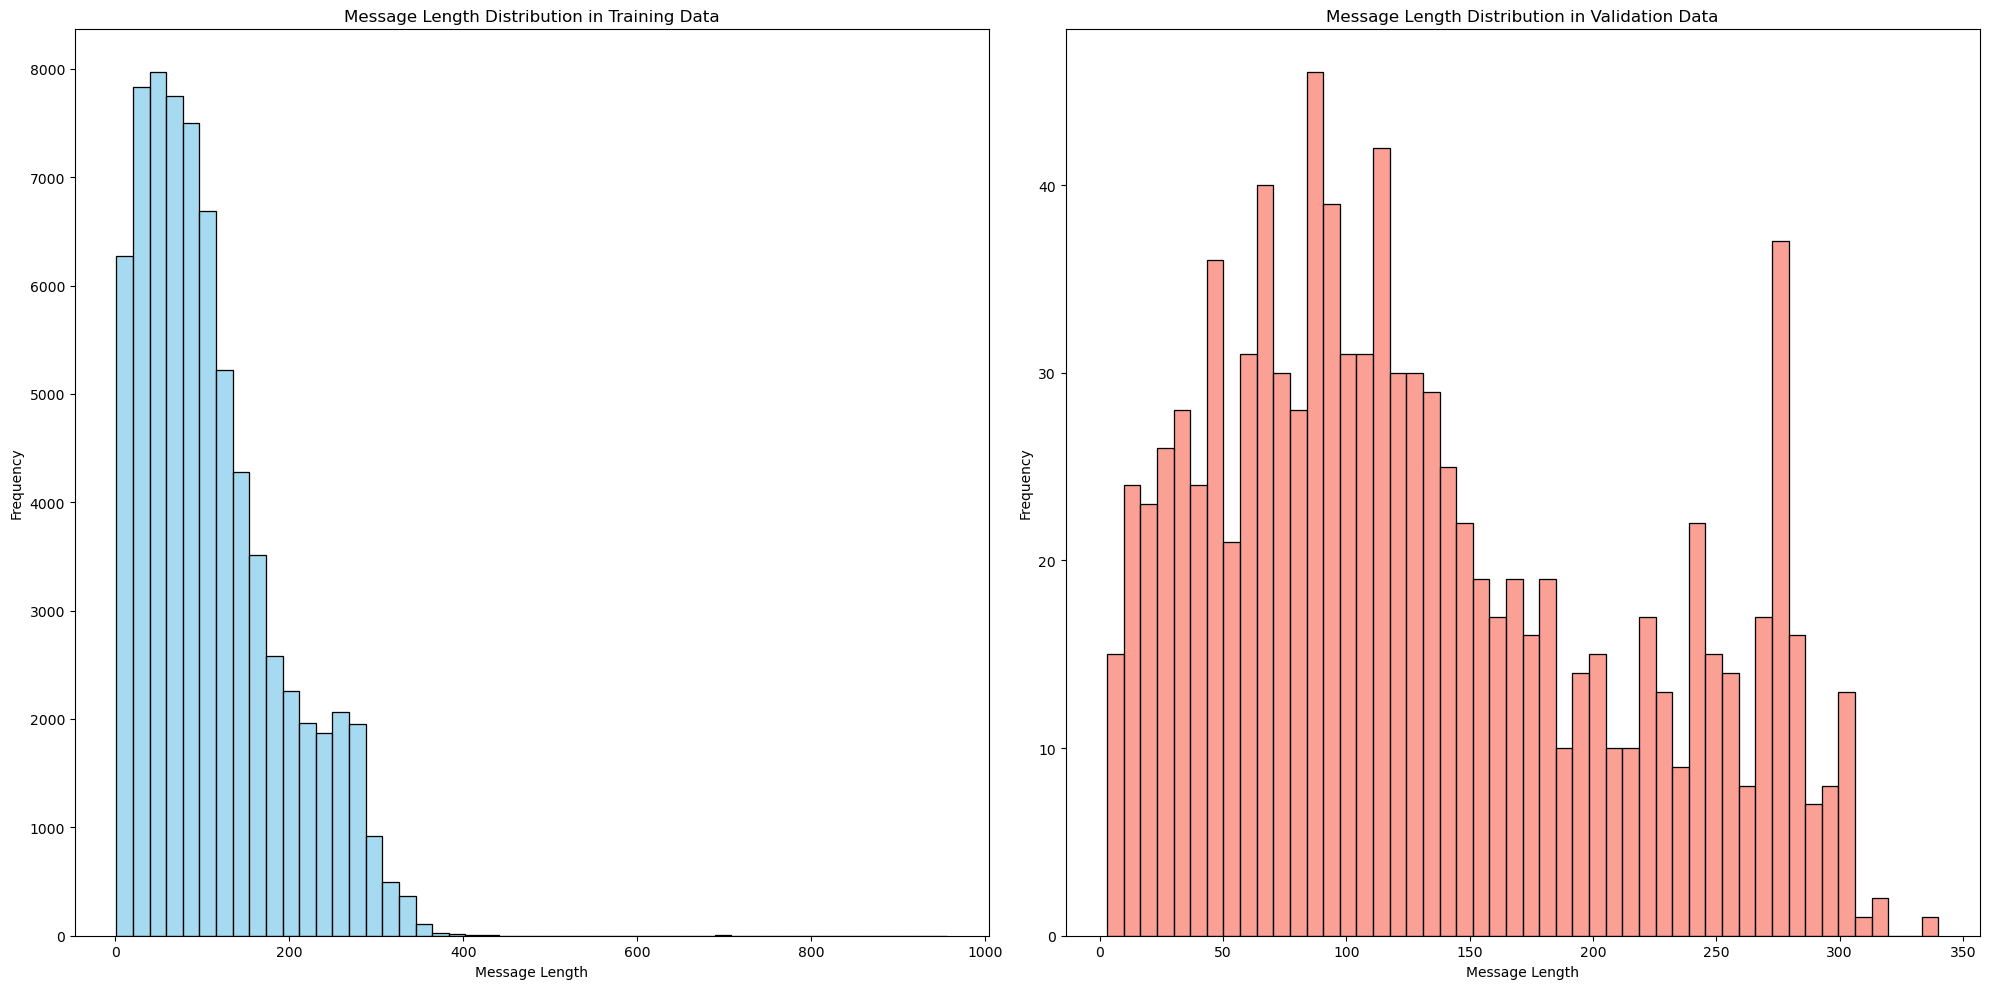

In [13]:
#Calculating the length of each message
train_data_cleaned['message_length'] = train_data_cleaned[train_data_cleaned.columns[3]].apply(len)
df_test['message_length'] = df_test[df_test.columns[3]].apply(len)

#Setting up the plots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

#Plotting message length distribution for training data
sns.histplot(train_data_cleaned['message_length'], bins=50, ax=ax[0], color='skyblue')
ax[0].set_title('Message Length Distribution in Training Data')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Message Length')

#Plotting message length distribution for validation data
sns.histplot(df_test['message_length'], bins=50, ax=ax[1], color='salmon')
ax[1].set_title('Message Length Distribution in Validation Data')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Message Length')

plt.tight_layout()
plt.show()

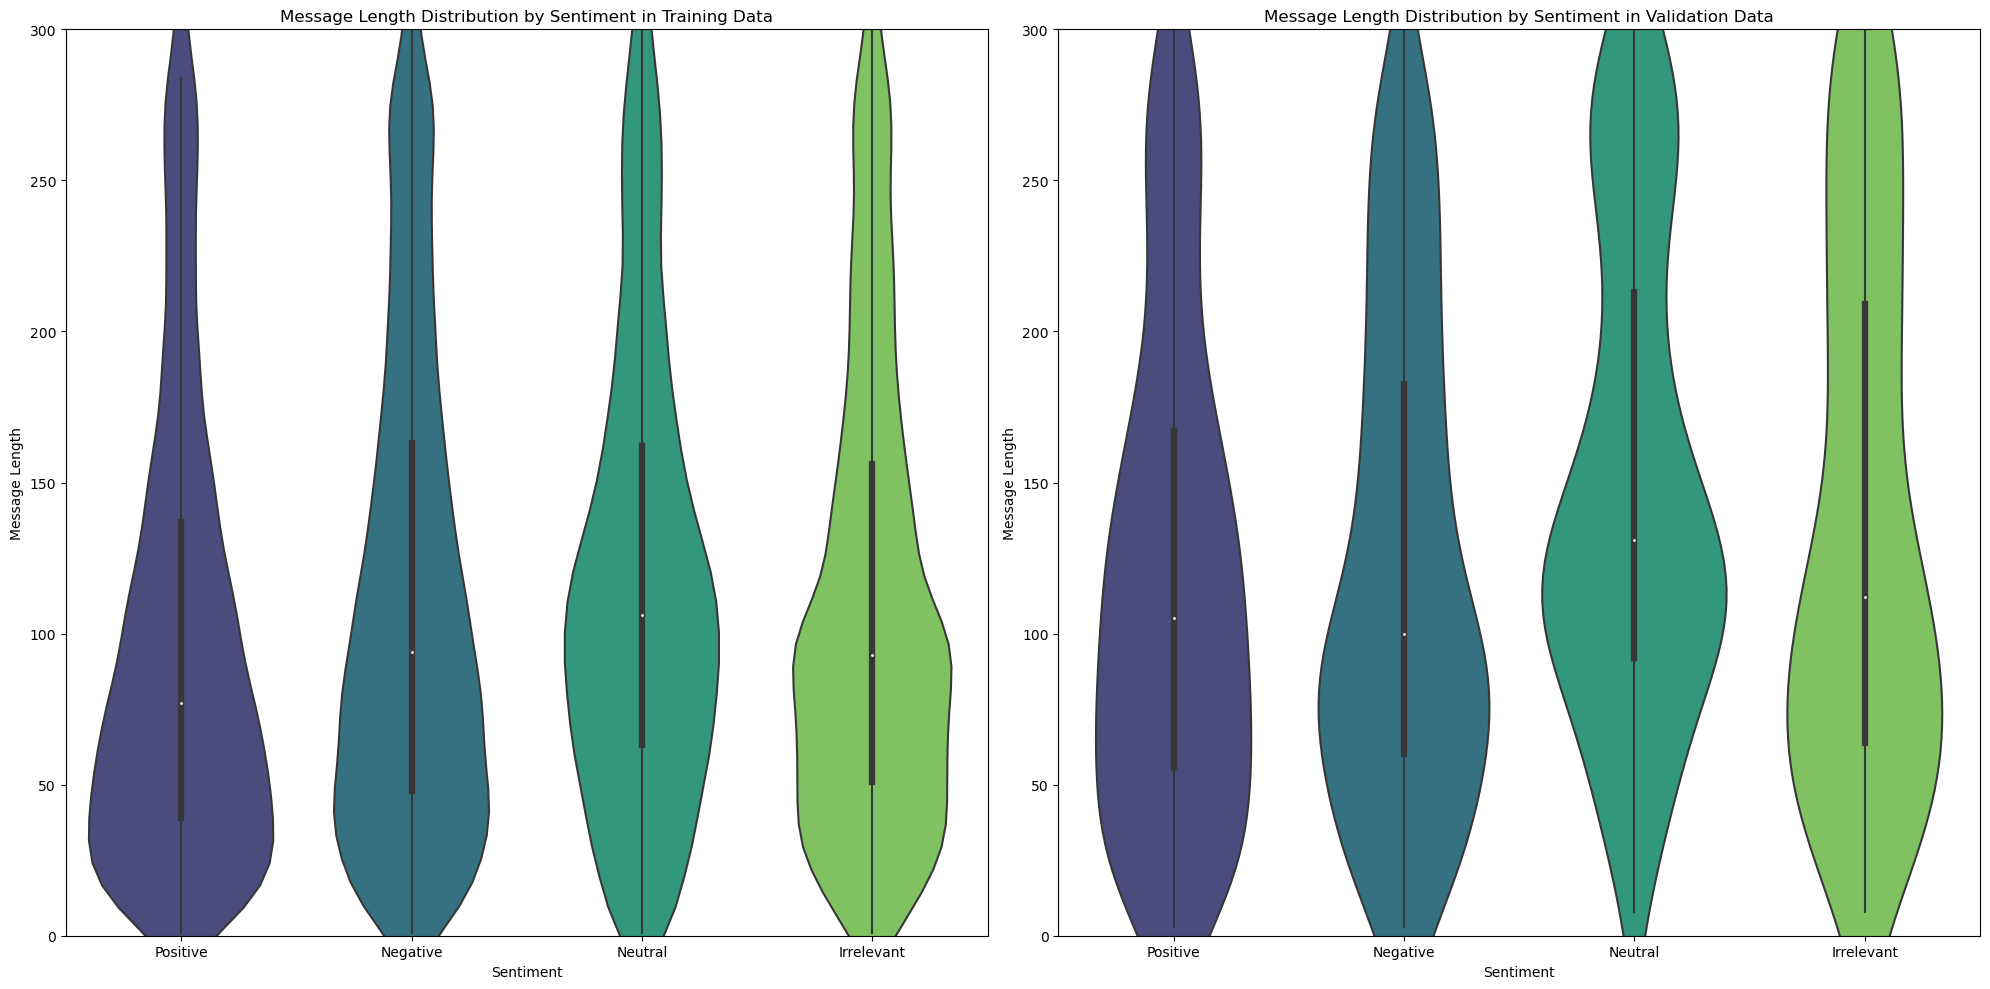

In [14]:
# Setting up the plots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plotting message length distribution by sentiment for training data using violin plot
sns.violinplot(data=train_data_cleaned, x=train_data_cleaned.columns[2], y='message_length', ax=ax[0], palette='viridis', order=['Positive', 'Negative', 'Neutral', 'Irrelevant'])
ax[0].set_title('Message Length Distribution by Sentiment in Training Data')
ax[0].set_ylabel('Message Length')
ax[0].set_xlabel('Sentiment')
ax[0].set_ylim(0, 300)  # Limiting y-axis for better visualization

# Plotting message length distribution by sentiment for validation data using violin plot
sns.violinplot(data=df_test, x=df_test.columns[2], y='message_length', ax=ax[1], palette='viridis', order=['Positive', 'Negative', 'Neutral', 'Irrelevant'])
ax[1].set_title('Message Length Distribution by Sentiment in Validation Data')
ax[1].set_ylabel('Message Length')
ax[1].set_xlabel('Sentiment')
ax[1].set_ylim(0, 300)  # Limiting y-axis for better visualization

plt.tight_layout()
plt.show()

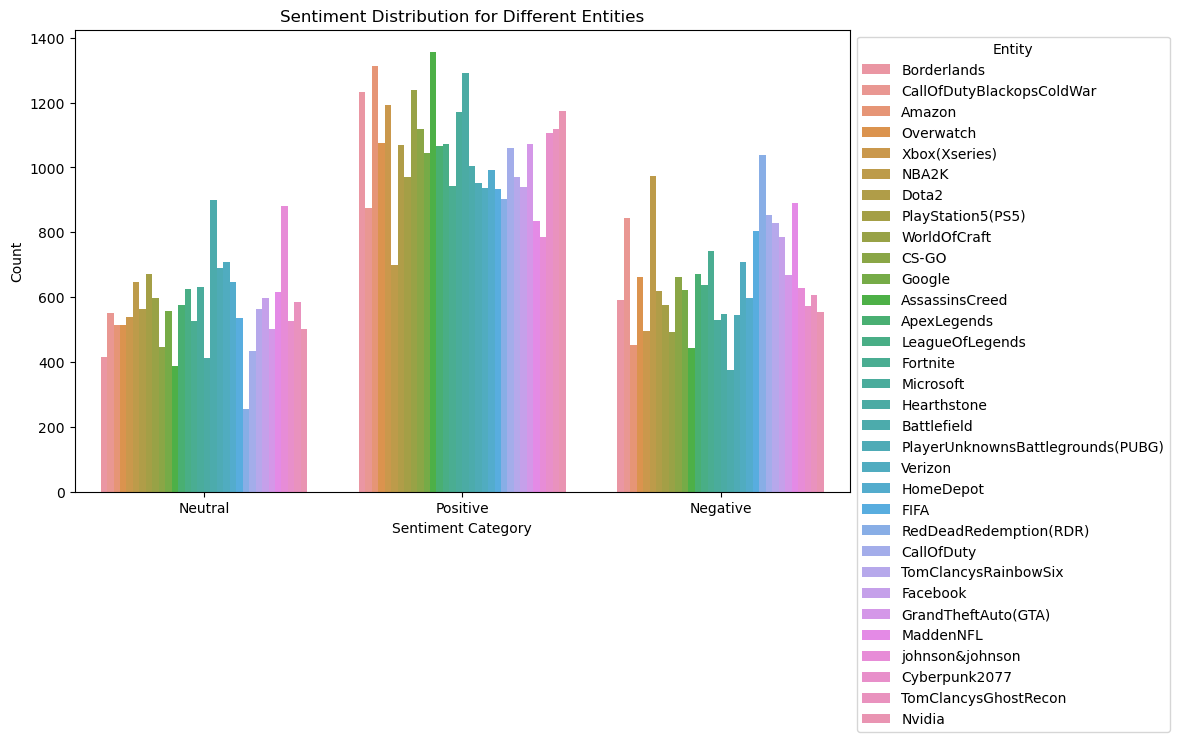

In [15]:
# Concatenate train and test data for a comprehensive analysis
all_data = pd.concat([train_data_cleaned, df_test], ignore_index=True)

# Sentiment analysis using TextBlob
all_data['polarity'] = all_data['Tweet content'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Map polarity values to sentiment categories
all_data['sentiment_category'] = all_data['polarity'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='sentiment_category', data=all_data, hue='entity')

# Move the legend to the side
ax.legend(title='Entity', bbox_to_anchor=(1, 1), loc='upper left')

plt.title('Sentiment Distribution for Different Entities')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

In [17]:
def preprocess_text_simplified(text):
    #Converting to lowercase
    text = text.lower()
    #Simple tokenization using split (without relying on NLTK)
    tokens = text.split()
    #Removing special characters and numbers
    tokens = [token for token in tokens if token.isalpha()]
    return " ".join(tokens)

#Applying simplified preprocessing to training data
train_data_cleaned['processed_message_simplified'] = train_data_cleaned[train_data_cleaned.columns[3]].apply(preprocess_text_simplified)

#Extracting most frequent terms using CountVectorizer with simplified preprocessing
vectorizer_simplified = CountVectorizer(max_features=20)
X_simplified = vectorizer_simplified.fit_transform(train_data_cleaned['processed_message_simplified'])
frequent_terms_simplified = vectorizer_simplified.get_feature_names_out()

frequent_terms_simplified


array(['and', 'but', 'for', 'game', 'have', 'in', 'is', 'it', 'just',
       'my', 'not', 'of', 'on', 'so', 'that', 'the', 'this', 'to', 'with',
       'you'], dtype=object)

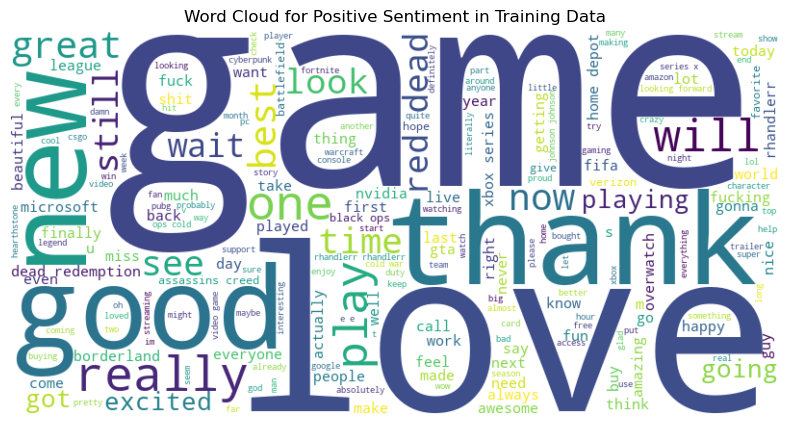

Accuracy: 0.8050

Classification Report:
               precision    recall  f1-score   support

    Negative       0.79      0.79      0.79       266
     Neutral       0.82      0.82      0.82       457
    Positive       0.79      0.78      0.79       277

    accuracy                           0.81      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.81      0.81      0.80      1000



In [19]:
#Adjusting the labels: Convert "Irrelevant" labels to "Neutral"
train_data_cleaned[train_data_cleaned.columns[2]] = train_data_cleaned[train_data_cleaned.columns[2]].replace('Irrelevant', 'Neutral')
df_test[df_test.columns[2]] = df_test[df_test.columns[2]].replace('Irrelevant', 'Neutral')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function for text preprocessing
def preprocess_text_simplified(text):
    return ' '.join([word.lower() for word in text.split() if word.isalpha()])

# Apply preprocessing to training and test data
train_data_cleaned['processed_message_simplified'] = train_data_cleaned['Tweet content'].apply(preprocess_text_simplified)
df_test['processed_message_simplified'] = df_test[df_test.columns[3]].apply(preprocess_text_simplified)

# Update sentiment labels: Convert "Irrelevant" labels to "Neutral"
train_data_cleaned['sentiment'] = train_data_cleaned['sentiment'].replace('Irrelevant', 'Neutral')
df_test['sentiment'] = df_test['sentiment'].replace('Irrelevant', 'Neutral')

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the preprocessed text from the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data_cleaned['processed_message_simplified'])
X_validation_tfidf = tfidf_vectorizer.transform(df_test['processed_message_simplified'])

# Extract target labels for training and validation
y_train = train_data_cleaned['sentiment']
y_validation = df_test['sentiment']

# Word cloud for Positive sentiment in training data
positive_text = " ".join(tweet for tweet in train_data_cleaned[train_data_cleaned['sentiment'] == 'Positive']['processed_message_simplified'])
wordcloud_positive = WordCloud(background_color='white', width=800, height=400).generate(positive_text)

# Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment in Training Data')
plt.show()

# Creating the ML pipeline with TF-IDF vectorization and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', LogisticRegression(solver='sag', multi_class='auto', max_iter=10000))
])

# Training the pipeline model using the training data
pipeline.fit(train_data_cleaned['processed_message_simplified'], y_train)

# Make predictions on the validation data
y_pred = pipeline.predict(df_test['processed_message_simplified'])

# Evaluate the model
accuracy = accuracy_score(y_validation, y_pred)
classification_rep = classification_report(y_validation, y_pred)

print(f"Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", classification_rep)